# 케라스 전이 학습(Transfer Learning)

<img src="https://miro.medium.com/max/5252/1*Z11P-CjNYWBofEbmGQrptA.png">

<sub>출처: https://medium.com/the-official-integrate-ai-blog/transfer-learning-explained-7d275c1e34e2</sub>


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *

In [ ]:
vgg16 = VGG16(weights='imagenet',
              input_shape=(32, 32, 3), include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 14,849,610
Trainable params: 14,849,098
Non-trainable params: 512
__________________________________________

In [ ]:
mobilenet = MobileNet(weights=None, input_shape=None, include_top=True)

resnet50 = ResNet50(weights=None, input_shape=None, include_top=True)

xception = Xception(weights=None, input_shape=None, include_top=True)

### 예제 : Dogs vs Cats
- Kaggle Data 이용: https://www.kaggle.com/c/dogs-vs-cats/data

- ImageDataGenerator의 flow_from_directory 이용

- 런타임 유형 GPU 사용

- 출처: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=SdW6geEVi2S8

#### modules import

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Input, Dropout, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')


#### 데이터 로드

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
  /content/cats_and_dogs_filtered.zip

--2020-09-27 20:05:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   135MB/s    in 0.5s    

2020-09-27 20:05:14 (135 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

#### 이미지 보강된 데이터 확인

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

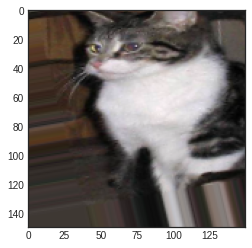

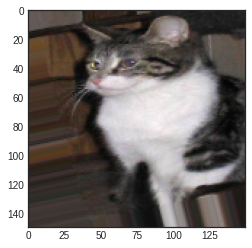

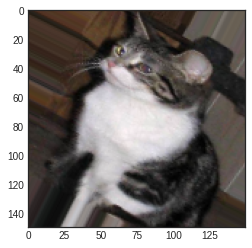

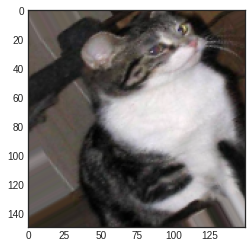

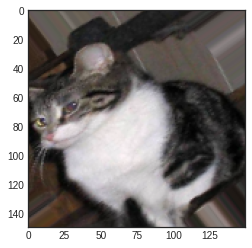

In [ ]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x.reshape((1, ) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break


#### 학습, 검증 데이터셋의 Data Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 구성 및 컴파일

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 2)         514       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 69, 69, 128)       2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147968)           

#### 모델 학습 및 학습 과정 시각화
- 런타임유형 GPU 사용

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    batch_size=256,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=2)

Epoch 1/30
100/100 - 17s - loss: 0.6890 - acc: 0.5240 - val_loss: 0.6830 - val_acc: 0.4990
Epoch 2/30
100/100 - 17s - loss: 0.6642 - acc: 0.5885 - val_loss: 0.6150 - val_acc: 0.6590
Epoch 3/30
100/100 - 17s - loss: 0.6427 - acc: 0.6065 - val_loss: 0.6032 - val_acc: 0.6460
Epoch 4/30
100/100 - 17s - loss: 0.6163 - acc: 0.6470 - val_loss: 0.6786 - val_acc: 0.5920
Epoch 5/30
100/100 - 17s - loss: 0.6191 - acc: 0.6605 - val_loss: 0.5915 - val_acc: 0.6560
Epoch 6/30
100/100 - 17s - loss: 0.6140 - acc: 0.6615 - val_loss: 0.5682 - val_acc: 0.7000
Epoch 7/30
100/100 - 17s - loss: 0.5946 - acc: 0.6810 - val_loss: 0.5757 - val_acc: 0.7000
Epoch 8/30
100/100 - 17s - loss: 0.5896 - acc: 0.6780 - val_loss: 0.5692 - val_acc: 0.7000
Epoch 9/30
100/100 - 17s - loss: 0.5851 - acc: 0.6910 - val_loss: 0.5702 - val_acc: 0.6960
Epoch 10/30
100/100 - 17s - loss: 0.5885 - acc: 0.6885 - val_loss: 0.5595 - val_acc: 0.7020
Epoch 11/30
100/100 - 17s - loss: 0.5763 - acc: 0.6910 - val_loss: 0.5578 - val_acc: 0.71

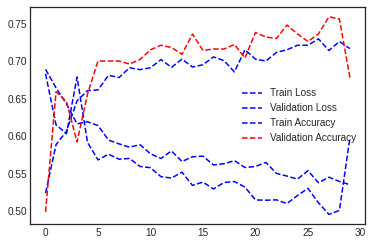

In [ ]:
acc=history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
plt.grid()
plt.legend()

plt.plot(epochs, acc, 'b--', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [ ]:
model.save("cats_and_dogs_model.h5")

### 사전 훈련된 모델 사용

In [ ]:
conv_base = VGG16(weights='imagenet',
                  input_shape=(150, 150, 3), include_top=False)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

def build_model_width_pretrained(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=2e-5),
                metrics=['accuracy'])
  
  return model

파라미터의 수 확인!

In [ ]:
model = build_model_width_pretrained(conv_base)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


#### 레이어 동결
- 훈련하기 전, 합성곱 기반 레이어들의 가중치 학습을 막기 위해 이를 동결

In [ ]:
print(len(model.trainable_weights))

30


In [ ]:
conv_base.trainable = False
print(len(model.trainable_weights))

4


#### 모델 컴파일
- trainable 속성을 변경했기 때문에 다시 모델을 컴파일 해야함

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=2e-5),
              metrics=['accuracy'])

#### 이미지 제너레이터

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 재학습

In [ ]:
history2 = model.fit(train_generator,
                     steps_per_epoch=100,
                     epochs=30,
                     batch_size=256,
                     validation_data=validation_generator,
                     validation_steps=50,
                     verbose=2)

Epoch 1/30
100/100 - 18s - loss: 0.5882 - accuracy: 0.7085 - val_loss: 0.4450 - val_accuracy: 0.8180
Epoch 2/30
100/100 - 18s - loss: 0.4744 - accuracy: 0.7835 - val_loss: 0.3764 - val_accuracy: 0.8340
Epoch 3/30
100/100 - 18s - loss: 0.4302 - accuracy: 0.8165 - val_loss: 0.3496 - val_accuracy: 0.8390
Epoch 4/30
100/100 - 18s - loss: 0.4103 - accuracy: 0.8175 - val_loss: 0.3230 - val_accuracy: 0.8580
Epoch 5/30
100/100 - 18s - loss: 0.3939 - accuracy: 0.8285 - val_loss: 0.3008 - val_accuracy: 0.8770
Epoch 6/30
100/100 - 18s - loss: 0.3697 - accuracy: 0.8430 - val_loss: 0.2880 - val_accuracy: 0.8810
Epoch 7/30
100/100 - 18s - loss: 0.3567 - accuracy: 0.8420 - val_loss: 0.2794 - val_accuracy: 0.8830
Epoch 8/30
100/100 - 18s - loss: 0.3378 - accuracy: 0.8610 - val_loss: 0.2898 - val_accuracy: 0.8720
Epoch 9/30
100/100 - 18s - loss: 0.3444 - accuracy: 0.8440 - val_loss: 0.2742 - val_accuracy: 0.8780
Epoch 10/30
100/100 - 18s - loss: 0.3265 - accuracy: 0.8545 - val_loss: 0.2662 - val_accura

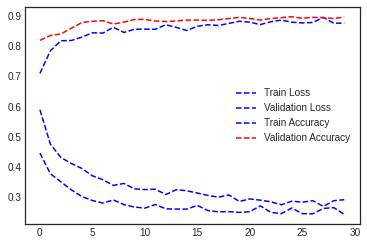

In [ ]:
acc=history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
plt.grid()
plt.legend()

plt.plot(epochs, acc, 'b--', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [ ]:
model.save('cats_and_dogs_with_pretrained_model.h5')

## Feature Map 시각화

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

### 모델 구성

In [ ]:
model = load_model('/content/cats_and_dogs_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 2)         514       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 69, 69, 128)       2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147968)           

In [ ]:
image_path = '/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor[np.newaxis, ...]
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


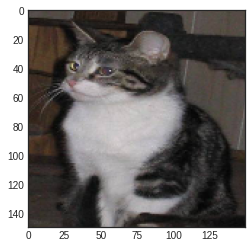

In [ ]:
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
conv_output = [layer.output for layer in model.layers[:8]]
conv_output

[<tf.Tensor 'conv2d_4/Relu_1:0' shape=(None, 148, 148, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d/MaxPool_1:0' shape=(None, 74, 74, 32) dtype=float32>,
 <tf.Tensor 'conv2d_5/Relu_1:0' shape=(None, 72, 72, 64) dtype=float32>,
 <tf.Tensor 'conv2d_6/BiasAdd_1:0' shape=(None, 71, 71, 2) dtype=float32>,
 <tf.Tensor 'conv2d_7/Relu_1:0' shape=(None, 69, 69, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool_1:0' shape=(None, 34, 34, 128) dtype=float32>,
 <tf.Tensor 'flatten_1/Reshape_1:0' shape=(None, 147968) dtype=float32>,
 <tf.Tensor 'dropout/cond_2/Identity:0' shape=(None, 147968) dtype=float32>]

In [ ]:
activation_model = Model(inputs=[model.input], outputs=conv_output)

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
len(activations)

8

### 시각화

(1, 148, 148, 32)


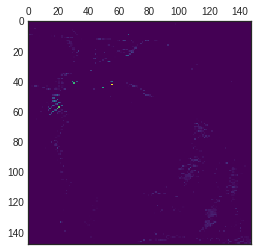

In [ ]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 7], cmap='viridis')
plt.show()

(1, 148, 148, 32)


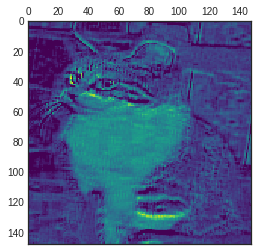

In [ ]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 10], cmap='viridis')
plt.show()

(1, 148, 148, 32)


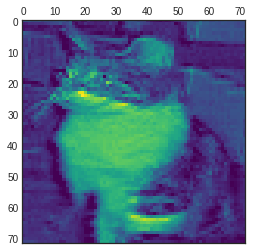

In [ ]:
print(activations[0].shape)
plt.matshow(activations[2][0, :, :, 20], cmap='viridis')
plt.show()

### 중간의 모든 활성화에 대해 시각화

ValueError: ignored

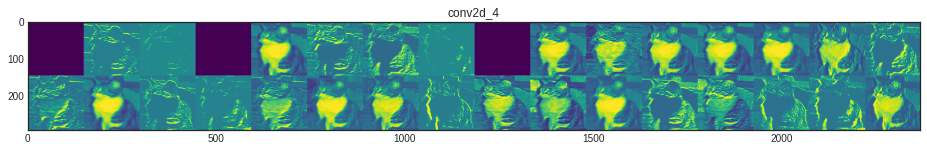

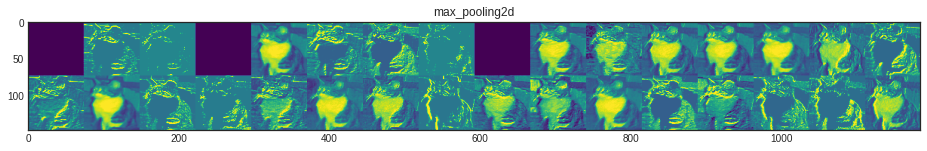

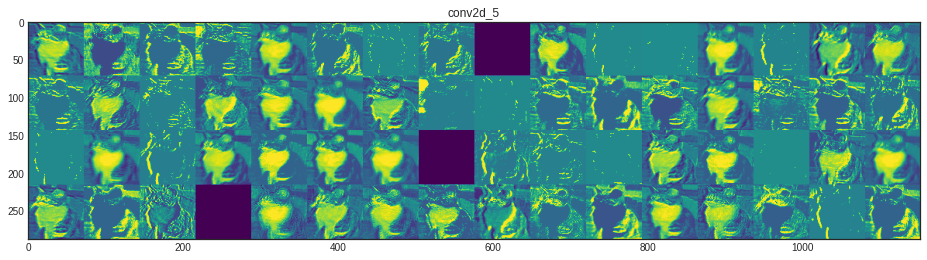

In [ ]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  num_features = layer_activation.shape[-1]

  size = layer_activation.shape[1]

  num_cols = num_features // images_per_row
  display_grid = np.zeros((size * num_cols, images_per_row * size))

  for col in range(num_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size: (col+1) * size, row * size : (row+1) * size] = channel_image

  scale = 1. /size

  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))

  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()
#이부분만 한시간 넘게 오류를 찾았는데 못찾아서 오류인채로 남겨두었습니다ㅠ..